In [1]:
import numpy as np
from numpy import newaxis as na
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib
from filter_detector_properties import *

def nHgCdTe(wavelength, force_old=False, force_short=False):

    # Computes the (complex) refractive index for HgCdTe for a given wavelength
    # Can probably make this a helper function at a later stage 

        E = 1.23984198405504/wavelength # in eV
        T = 89.
        x = 0.445

        # Djuri\v si\'c & Li, J. Appl. Phys.85:2854 (1999)

        # parameters: Table II: a0i*(1-x) + (a1i+a2i*x)*x*(1-x) + a3i*x
        def f(a0,a1,a2,a3,x):
            return(a0*(1-x)+(a1+a2*x)*x*(1-x)+a3*x)

        epsilon_inf = f(1.665,0.644,-1.339,1.252,x)
        epsilon_inf = 1.938

        # E0 transition
        E0 = -0.302 +1.93*x + 5.35*(1-2*x)*T/1e4 - 0.81*x**2 + 0.832*x**3
        Delta0 = f(0.654,0.778,-2.626,2.456,x) - E0
        Gamma0 = f(0.025,6.119,-1.784,0.487,x)/10.
        A = f(3.100,-6.988,1.974,5.098,x)
        Delta0 = 1.544-E0; Gamma0 = 0.0358; A = 1.003
        chi0 = (E+1j*Gamma0)/E0
        chi0s = (E+1j*Gamma0)/(E0+Delta0)
        epsilonI = A/E0**1.5*(  1/chi0**2*(2-np.sqrt(1+chi0)-np.sqrt(1-chi0))
          + 0.5*(E0/(E0+Delta0))**1.5/chi0s**2*(2-np.sqrt(1+chi0s)-np.sqrt(1-chi0s)) )
        #
        # exciton contribution
        epsilon0x = 0.
        A0x = f(0.003,2.505,-3.000,0.010,x)
        G03D = f(0.002,3.084,-3.589,0.001,x)
        A0x = 0.011; G03D = 0.013
        for m in range(1,100):
            epsilon0x += A0x/m**3/(E0 - G03D/m**2 - E - 1j*Gamma0)

        # E1 transition
        E1 = 2.147+0.44*x+0.7*x**2
        Delta1 = 2.778+0.47*x+0.6*x**2 - E1
        Gamma1 = f(1.349,3.421,10.095,1.904,x)/10.
        B1 = f(1.320,5.542,-3.599,1.816,x)
        B1s = f(0.240,4.289,-4.040,1.055,x)
        Gamma1 = 0.2307; B1 = 1.726; B1s = 0.156
        chi1 = (E+1j*Gamma1)/E1
        chi1s = (E+1j*Gamma1)/(E1+Delta1)
        epsilonII = -B1/chi1**2*np.log(1-chi1**2) - B1s/chi1s**2*np.log(1-chi1s**2)
        #
        # exciton contribution
        epsilonIII = 0.
        B1x = f(0.453,2.604,-0.066,1.029,x)
        B2x = f(0.248,1.100,0.373,0.666,x)
        G1 = f(0.054,-0.378,0.664,0.001,x)
        G1s = f(0.057,-0.212,0.384,0.013,x)
        B1x = 0.746; B2x = 0.356; G1 = 1e-4; G1s = 1e-3
        for m in range(1,100):
            nn = 2*m-1
            epsilonIII += 1/nn**3*( B1x/(E1-G1/nn**2-E-1j*Gamma1) + B2x/(E1+Delta1-G1s/nn**2-E-1j*Gamma1) )

        # higher critical points
        #
        epsilonIV = 0.
        # sum fj^2 / (Ej^2 - E^2 - i E Gammaj')
        f2 = f(4.526,6.421,-9.926,5.232,x)
        Gamma2 = f(1.167,0.873,0.481,0.734,x)
        alpha2 = f(0.397,-0.010,0.119,0.022,x)
        E2 = f(4.559,0.506,-0.856,5.089,x)
        f2 = 4.407; Gamma2 = 1.082; alpha2 = 0.029; E2 = 4.798
        Gamma2p = Gamma2*np.exp(-alpha2*((E-E2)/Gamma2)**2)
        epsilonIV += f2**2/(E2**2-E**2-1j*E*Gamma2p)
        #
        f3 = f(6.147,6.139,-8.472,1.861,x)
        Gamma3 = f(1.946,0.808,-0.944,0.087,x)
        alpha3 = f(0.173,-1.905,4.202,0.160,x)
        E3 = f(6.499,1.564,1.374,6.356,x)
        f3 = 4.422; Gamma3 = 3.726; alpha3 = 0.081; E3 = 5.432
        Gamma3p = Gamma3*np.exp(-alpha3*((E-E3)/Gamma3)**2)
        epsilonIV += f3**2/(E3**2-E**2-1j*E*Gamma3p)
        #
        f4 = f(8.750,0,0,2.033,x)
        Gamma4 = f(4.146,0,0,0.929,x)
        alpha4 = f(0.797,0,0,0.014,x)
        E4 = f(2.919,3.472,-6.331,2.890,x)
        f4 = 8.122; Gamma4 = 4.854; alpha4 = 0.066; E4 = 3.905
        Gamma4p = Gamma4*np.exp(-alpha4*((E-E4)/Gamma4)**2)
        epsilonIV += f4**2/(E4**2-E**2-1j*E*Gamma4p)

        n = np.sqrt(epsilon_inf + epsilonI + epsilon0x + epsilonII + epsilonIII + epsilonIV)

        # conversion to MCT221
        if ((wavelength>1.000001) or force_old) and (not force_short):
            alphag = -65+1.88*T+(8694-10.31*T)*x
            Eg = -0.295+1.87*x-0.28*x**2+(6-14*x+3*x**2)/1e4*T+.35*x**4
            E = 1.23984198405504/wavelength
            beta = -1+.083*T + (21-.13*T)*x
            if E>Eg:
                alpha = alphag*np.exp(np.sqrt(beta*(E-Eg))) / 1e4 # per micron
            else:
                alpha0 = np.exp(-18.5+45.68*x)
                E0 = -0.355+1.77*x
                alpha = alpha0 * np.exp((E-E0)/(Eg-E0)*np.log(alphag/alpha0)) / 1e4 # per micron
            n_imag = alpha*wavelength/4./np.pi

            new_wt = 1.
            if not force_old:
                if wavelength>1.500001:
                    n += (n_imag-np.imag(n))*new_wt*1j
                else:
                    n_imag2 = 0.626123540873-0.100178870601*wavelength-0.165418727091*wavelength**2+0.051115994240*wavelength**3
                    n += (n_imag2-np.imag(n))*new_wt*1j
            if force_old: n+= (n_imag-np.imag(n))*1j
        

        
        return(n)

In [24]:
wavelength = 1.0
n = 1.23
e = n**2
optical_th_list = np.linspace(0,1*wavelength,num=1000)
th_list = optical_th_list/n

ux=0
uy=0
k0 = 2*np.pi/wavelength

Tr_TE = []
Tr_TM = []

n_HgCdTe = nHgCdTe(wavelength)
e_HgCdTe = n_HgCdTe**2
kz_HgCdTe = np.sqrt((k0**2)*((n_HgCdTe**2)-(ux**2)-(uy**2)))

p_TE_HgCdTe = kz_HgCdTe/k0
p_TM_HgCdTe = kz_HgCdTe/k0/e_HgCdTe


for index_th in range(len(th_list)):
    th = th_list[index_th]

    sin_theta_in_medium = np.sqrt((ux**2)+(uy**2))/n
    cos_theta_in_medium = np.sqrt(1 - (sin_theta_in_medium**2))

    sin_theta = np.sqrt((ux**2)+(uy**2))
    cos_theta = np.sqrt(1-(sin_theta**2))

    
    p_TE = n*cos_theta_in_medium
    p_TM = (1./n)*cos_theta_in_medium


    glass = filter_detector(n,th/3,n,th/3,n,th/3,1)

    #characteristic_matrices = glass.characteristic_matrix(wavelength,ux,uy)

    #M_TE = characteristic_matrices['TE']
    #M_TM = characteristic_matrices['TM']

    T_coeff = glass.Transmission(wavelength, ux, uy, use_HgCdTe=False)
    T_TE = T_coeff['TE']
    T_TM = T_coeff['TM']


    Tr_TE.append((T_TE.real**2 + T_TE.imag**2)*1)
    Tr_TM.append((T_TM.real**2 + T_TM.imag**2)*1)

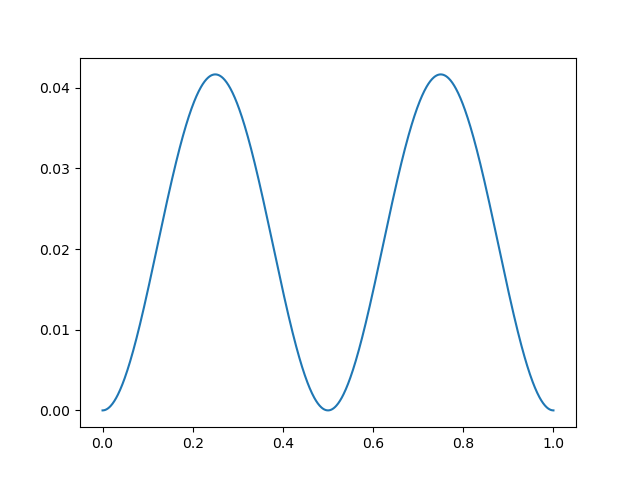

In [25]:
fig,ax=plt.subplots()
ax.set_xscale('linear')
ax.set_yscale('linear')

ax.plot(optical_th_list, 1-np.array(Tr_TM))
plt.show()